<a href="https://colab.research.google.com/github/ryo-1129/AML_Midterm_Assignment/blob/main/shimosaka_final_ryosukeI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

# Datasets

In [53]:
# dataset 4
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1


In [ ]:
# dataset 5
n = 200
x_d5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = np.argmax(np.dot(np.hstack([x_d5[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

# Problem 1

In [ ]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy


In [54]:
# 200*5 (5列目はオフセット)
x = np.concatenate([x_d4, np.ones((x_d4.shape[0], 1))], 1)
# 200次元のラベル{+1, -1}
y = y_d4

num_iter = 100
lam = 0.01

def wx (ww, x):
  return ww[0] * x[:,0] + ww[1] * x[:,1] + ww[2] * x[:,2] + ww[3] * x[:,3] + ww[4] * x[:,4]

# 5次元ベクトルの勾配
def grad(posterior, y, x, lam, ww):
  grad = np.zeros(5)
  for i in range(5):
    grad[i] = 1/n * np.sum((1-posterior) * (-y) * x[:, i]) + 2 * lam * ww[i]

  return grad

# 5*5のヘッセ行列
def hess(posterior, y, x, lam):
  hess = np.zeros((5,5))
  for i in range(5):
    for j in range(5):
      hess[i,j] = 1/n * np.sum((1-posterior) * posterior * y * y * x[:, i] * x[:, j])
      if (i == j):
        hess[i,j] += 2 * lam
  return hess

In [55]:
loss_hist_batch = [] # to store the history of loss J(w_t)

# implement batch steepest gradient method here

ww = 3*np.ones(5)
alpha = 0.5
lip = np.zeros(5)
for i in range(5):
  lip[i] = 0.25 * max(x[:, i] ** 2)

for t in range(num_iter):
  posterior = 1/(1+np.exp(-y * (wx(ww,x))))

  direction = grad(posterior, y, x, lam, ww)
  j = 1/n * np.sum(np.log(1.0 + np.exp(-y * wx(ww, x)))) + lam * np.inner(ww,ww)
  loss_hist_batch.append(j)
  ww = ww - alpha * 1.0 / lip * direction 


In [56]:
loss_hist_newton = [] # to store the history of loss J(w_t)

# implement Newton based method here
ww = 3*np.ones(5)

for t in range(num_iter):
  posterior = 1/(1+np.exp(-y * (wx(ww,x))))

  g = grad(posterior, y, x, lam, ww)
  h = hess(posterior, y, x, lam)

  j = 1/n * np.sum(np.log(1.0 + np.exp(-y * wx(ww, x)))) + lam * np.inner(ww,ww)
  loss_hist_newton.append(j)
  ww = ww - np.dot(np.linalg.inv(h), g) * 1.0 / np.sqrt(t + 10)


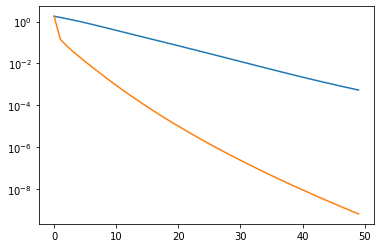

In [57]:
# plot the result
show_iter = 50
j_hat = min(min(loss_hist_batch), min(loss_hist_newton))
plt.yscale('log')
plt.plot(loss_hist_batch[:show_iter] - j_hat, label='steepest')
plt.plot(loss_hist_newton[:show_iter] - j_hat, label='newton')

In [ ]:
# steepest gradient method
x5 = np.concatenate([x_d5, np.ones((x_d5.shape[0], 1))], 1)
y5 = y_d5

multi_loss_hist_steepest = []
num_iter2 = 100
num_class = 3
alpha = 0.01

W = 3 * np.ones((5, num_class))

def Wx (W, x):
  return np.dot(x, W)

def soft_max(z):
  y = np.zeros(z.shape)
  for i in range(num_class):
    y[:, i] = np.exp(z[:, i]) / np.sum((np.exp(z)), 1)
  return y

def onehot(y):
  T = np.zeros((y.size, num_class))
  for data in range(y.size):
    T[data, y[data]] = 1
  return T

def get_loss(W, T, Y):
  return -np.sum(T * np.log(Y))

T = onehot(y5)

for t in range(num_iter2):
  Y = soft_max(Wx(W, x5))
  direction = np.dot(x5.T, T - Y)
  j = get_loss(W, T, Y)
  multi_loss_hist_steepest.append(j)
  W = W + alpha * direction

In [50]:
# newton method
x5 = np.concatenate([x_d5, np.ones((x_d5.shape[0], 1))], 1)
y5 = y_d5

multi_loss_hist_newton = []
num_iter2 = 100
num_class = 3

W = 3 * np.ones((5, num_class))

def Wx_newton (W, x):
  W = W.reshape([5, num_class])
  wx = np.dot(x, W)
  W = W.T.flatten()
  return wx

def R_(y, i, j):
  I = np.eye(n)
  R_ij = np.empty(n)
  for k in range(n):
    R_ij[k] = y[k,i] * (I[i, j] - y[k, j])
  return np.diag(R_ij)

def get_loss2(T, Y):
  delta = 1e-7
  return -np.sum(T * np.log(Y + delta))

def Hessian(y):
  H = np.empty([5 * num_class, 5 * num_class])
  for i in range(num_class):
    for j in range(num_class):
      R = R_(y, i, j)
      H[5 * j: 5 * j + 5, 5 * i:5*i+5] = 1/n * np.dot(np.dot(x5.T, R), x5)
  return H

T = onehot(y5)
W = W.T.flatten()
dw = np.zeros([5 * num_class])
for t in range(32):
  Y = soft_max(Wx_newton(W, x5))
  for k in range(num_class):
    dw[k * 5:k * 5 + 5] = 1/n * np.dot(x5.T, Y[:, k] - T[:, k])
  H = Hessian(Y)
  j = get_loss2(T, Y)
  multi_loss_hist_newton.append(j)
  W = W - np.dot(np.linalg.inv(H), dw)
W = W.reshape([5, num_class]).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


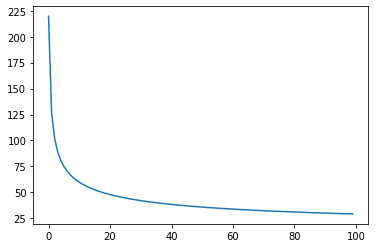

In [ ]:
plt.plot(multi_loss_hist_steepest)
# plt.plot(multi_loss_hist_newton)